In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from scipy.stats.mstats import winsorize

from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import datasets, metrics
from sklearn.manifold import TSNE
import umap

import time
from sqlalchemy import create_engine
import warnings
warnings.filterwarnings('ignore')

In [2]:
salary = pd.read_csv('salaries.csv')
batting = pd.read_csv('batting.csv')
fielding = pd.read_csv('fielding.csv')
pitching = pd.read_csv('pitching.csv')


In [3]:
def boxplot(df, figsize, num_columns):
    
    lst = list(df.select_dtypes(exclude='object'))
    fig = plt.figure(figsize=(figsize))
    for i, col in enumerate(lst):
    
        plt.subplot(len(lst), num_columns, i+1)
        plt.boxplot(df[col])
        plt.title('boxplot of {}'.format(col))
        plt.tight_layout()


In [4]:
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

In [5]:
# function to be able to check for outliers and a function
# to winsorize said outliers 
def check_outliers(df):
    lst = list(df.select_dtypes(exclude='object'))
    length = len(df)
    for col in lst:
        q75, q25 = np.percentile(df[col], [75 ,25])
        iqr = q75 - q25

        min_val = q25 - (iqr*1.5)
        max_val = q75 + (iqr*1.5)
        print("Number of outliers and percentage of it in {} : {} and %{}".format(col,
                                                                             len((np.where((df[col] > max_val) | 
                                                                                           (df[col] < min_val))[0])),len((np.where((df[col] > max_val) | 
                                                                                           (df[col] < min_val))[0]))*100/length))
    
    
        print('percent of outliers low')
        print(len(np.where(df[col] < min_val)[0]) /length)
        print('Percent of outliers high')
        print(len(np.where(df[col] > max_val)[0]) /length)
        print(90 * '-')
        
def winsorize_outliers(df):
    lst = list(df.select_dtypes(exclude='object'))
    length = len(df)
    for col in lst:
        q75, q25 = np.percentile(df[col], [75, 25])
        iqr = q75 - q25

        min_val = q25 - (iqr*1.5)
        max_val = q75 + (iqr*1.5)

        df[col] = winsorize(df[col], (len(np.where(df[col] < min_val)[0]) / length,
                                      len(np.where(df[col] > max_val)[
                                          0]) / length
                                      )
                            )

### This gem I found on towardsdatascience.com so I can't take credit, but it is a really clever solution to doing KNN imputation on a variable.

In [6]:
import numpy as np
import pandas as pd
from collections import defaultdict
from scipy.stats import hmean
from scipy.spatial.distance import cdist
from scipy import stats
import numbers


def weighted_hamming(data):
    """ Compute weighted hamming distance on categorical variables. For one variable, it is equal to 1 if
        the values between point A and point B are different, else it is equal the relative frequency of the
        distribution of the value across the variable. For multiple variables, the harmonic mean is computed
        up to a constant factor.
        @params:
            - data = a pandas data frame of categorical variables
        @returns:
            - distance_matrix = a distance matrix with pairwise distance for all attributes
    """
    categories_dist = []
    
    for category in data:
        X = pd.get_dummies(data[category])
        X_mean = X * X.mean()
        X_dot = X_mean.dot(X.transpose())
        X_np = np.asarray(X_dot.replace(0,1,inplace=False))
        categories_dist.append(X_np)
    categories_dist = np.array(categories_dist)
    distances = hmean(categories_dist, axis=0)
    return distances


def distance_matrix(data, numeric_distance = "euclidean", categorical_distance = "jaccard"):
    """ Compute the pairwise distance attribute by attribute in order to account for different variables type:
        - Continuous
        - Categorical
        For ordinal values, provide a numerical representation taking the order into account.
        Categorical variables are transformed into a set of binary ones.
        If both continuous and categorical distance are provided, a Gower-like distance is computed and the numeric
        variables are all normalized in the process.
        If there are missing values, the mean is computed for numerical attributes and the mode for categorical ones.
        
        Note: If weighted-hamming distance is chosen, the computation time increases a lot since it is not coded in C 
        like other distance metrics provided by scipy.
        @params:
            - data                  = pandas dataframe to compute distances on.
            - numeric_distances     = the metric to apply to continuous attributes.
                                      "euclidean" and "cityblock" available.
                                      Default = "euclidean"
            - categorical_distances = the metric to apply to binary attributes.
                                      "jaccard", "hamming", "weighted-hamming" and "euclidean"
                                      available. Default = "jaccard"
        @returns:
            - the distance matrix
    """
    possible_continuous_distances = ["euclidean", "cityblock"]
    possible_binary_distances = ["euclidean", "jaccard", "hamming", "weighted-hamming"]
    number_of_variables = data.shape[1]
    number_of_observations = data.shape[0]

    # Get the type of each attribute (Numeric or categorical)
    is_numeric = [all(isinstance(n, numbers.Number) for n in data.iloc[:, i]) for i, x in enumerate(data)]
    is_all_numeric = sum(is_numeric) == len(is_numeric)
    is_all_categorical = sum(is_numeric) == 0
    is_mixed_type = not is_all_categorical and not is_all_numeric

    # Check the content of the distances parameter
    if numeric_distance not in possible_continuous_distances:
        print("The continuous distance " + numeric_distance + " is not supported.")
        return None
    elif categorical_distance not in possible_binary_distances:
        print("The binary distance " + categorical_distance + " is not supported.")
        return None

    # Separate the data frame into categorical and numeric attributes and normalize numeric data
    if is_mixed_type:
        number_of_numeric_var = sum(is_numeric)
        number_of_categorical_var = number_of_variables - number_of_numeric_var
        data_numeric = data.iloc[:, is_numeric]
        data_numeric = (data_numeric - data_numeric.mean()) / (data_numeric.max() - data_numeric.min())
        data_categorical = data.iloc[:, [not x for x in is_numeric]]

    # Replace missing values with column mean for numeric values and mode for categorical ones. With the mode, it
    # triggers a warning: "SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame"
    # but the value are properly replaced
    if is_mixed_type:
        data_numeric.fillna(data_numeric.mean(), inplace=True)
        for x in data_categorical:
            data_categorical[x].fillna(data_categorical[x].mode()[0], inplace=True)
    elif is_all_numeric:
        data.fillna(data.mean(), inplace=True)
    else:
        for x in data:
            data[x].fillna(data[x].mode()[0], inplace=True)

    # "Dummifies" categorical variables in place
    if not is_all_numeric and not (categorical_distance == 'hamming' or categorical_distance == 'weighted-hamming'):
        if is_mixed_type:
            data_categorical = pd.get_dummies(data_categorical)
        else:
            data = pd.get_dummies(data)
    elif not is_all_numeric and categorical_distance == 'hamming':
        if is_mixed_type:
            data_categorical = pd.DataFrame([pd.factorize(data_categorical[x])[0] for x in data_categorical]).transpose()
        else:
            data = pd.DataFrame([pd.factorize(data[x])[0] for x in data]).transpose()

    if is_all_numeric:
        result_matrix = cdist(data, data, metric=numeric_distance)
    elif is_all_categorical:
        if categorical_distance == "weighted-hamming":
            result_matrix = weighted_hamming(data)
        else:
            result_matrix = cdist(data, data, metric=categorical_distance)
    else:
        result_numeric = cdist(data_numeric, data_numeric, metric=numeric_distance)
        if categorical_distance == "weighted-hamming":
            result_categorical = weighted_hamming(data_categorical)
        else:
            result_categorical = cdist(data_categorical, data_categorical, metric=categorical_distance)
        result_matrix = np.array([[1.0*(result_numeric[i, j] * number_of_numeric_var + result_categorical[i, j] *
                               number_of_categorical_var) / number_of_variables for j in range(number_of_observations)] for i in range(number_of_observations)])

    # Fill the diagonal with NaN values
    np.fill_diagonal(result_matrix, np.nan)

    return pd.DataFrame(result_matrix)


def knn_impute(target, attributes, k_neighbors, aggregation_method="mean", numeric_distance="euclidean",
               categorical_distance="jaccard", missing_neighbors_threshold = 0.5):
    """ Replace the missing values within the target variable based on its k nearest neighbors identified with the
        attributes variables. If more than 50% of its neighbors are also missing values, the value is not modified and
        remains missing. If there is a problem in the parameters provided, returns None.
        If to many neighbors also have missing values, leave the missing value of interest unchanged.
        @params:
            - target                        = a vector of n values with missing values that you want to impute. The length has
                                              to be at least n = 3.
            - attributes                    = a data frame of attributes with n rows to match the target variable
            - k_neighbors                   = the number of neighbors to look at to impute the missing values. It has to be a
                                              value between 1 and n.
            - aggregation_method            = how to aggregate the values from the nearest neighbors (mean, median, mode)
                                              Default = "mean"
            - numeric_distances             = the metric to apply to continuous attributes.
                                              "euclidean" and "cityblock" available.
                                              Default = "euclidean"
            - categorical_distances         = the metric to apply to binary attributes.
                                              "jaccard", "hamming", "weighted-hamming" and "euclidean"
                                              available. Default = "jaccard"
            - missing_neighbors_threshold   = minimum of neighbors among the k ones that are not also missing to infer
                                              the correct value. Default = 0.5
        @returns:
            target_completed        = the vector of target values with missing value replaced. If there is a problem
                                      in the parameters, return None
    """

    # Get useful variables
    possible_aggregation_method = ["mean", "median", "mode"]
    number_observations = len(target)
    is_target_numeric = all(isinstance(n, numbers.Number) for n in target)

    # Check for possible errors
    if number_observations < 3:
        print("Not enough observations.")
        return None
    if attributes.shape[0] != number_observations:
        print("The number of observations in the attributes variable is not matching the target variable length.")
        return None
    if k_neighbors > number_observations or k_neighbors < 1:
        print("The range of the number of neighbors is incorrect.")
        return None
    if aggregation_method not in possible_aggregation_method:
        print("The aggregation method is incorrect.")
        return None
    if not is_target_numeric and aggregation_method != "mode":
        print("The only method allowed for categorical target variable is the mode.")
        return None

    # Make sure the data are in the right format
    target = pd.DataFrame(target)
    attributes = pd.DataFrame(attributes)

    # Get the distance matrix and check whether no error was triggered when computing it
    distances = distance_matrix(attributes, numeric_distance, categorical_distance)
    if distances is None:
        return None

    # Get the closest points and compute the correct aggregation method
    for i, value in enumerate(target.iloc[:, 0]):
        if pd.isnull(value):
            order = distances.iloc[i,:].values.argsort()[:k_neighbors]
            closest_to_target = target.iloc[order, :]
            missing_neighbors = [x for x  in closest_to_target.isnull().iloc[:, 0]]
            # Compute the right aggregation method if at least more than 50% of the closest neighbors are not missing
            if sum(missing_neighbors) >= missing_neighbors_threshold * k_neighbors:
                continue
            elif aggregation_method == "mean":
                target.iloc[i] = np.ma.mean(np.ma.masked_array(closest_to_target,np.isnan(closest_to_target)))
            elif aggregation_method == "median":
                target.iloc[i] = np.ma.median(np.ma.masked_array(closest_to_target,np.isnan(closest_to_target)))
            else:
                target.iloc[i] = stats.mode(closest_to_target, nan_policy='omit')[0][0]

    return target

In [7]:
all_df = [salary, batting, fielding, pitching]
for df in all_df:
    print(get_df_name(df).upper(), '\n')
    print('length of {}:'.format(get_df_name(df)), len(df))
    print('=' * 40)
    display(df.head())


SALARY 

length of salary: 25575


,yearID,teamID,lgID,playerID,salary
0,1985,ATL,NL,barkele01,870000
1,1985,ATL,NL,bedrost01,550000
2,1985,ATL,NL,benedbr01,545000
3,1985,ATL,NL,campri01,633333
4,1985,ATL,NL,ceronri01,625000


BATTING 

length of batting: 101332


,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,abercda01,1871,1,TRO,NaN,1,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,addybo01,1871,1,RC1,NaN,25,118.0,30.0,32.0,6.0,...,13.0,8.0,1.0,4.0,0.0,NaN,NaN,NaN,NaN,NaN
2,allisar01,1871,1,CL1,NaN,29,137.0,28.0,40.0,4.0,...,19.0,3.0,1.0,2.0,5.0,NaN,NaN,NaN,NaN,NaN
3,allisdo01,1871,1,WS3,NaN,27,133.0,28.0,44.0,10.0,...,27.0,1.0,1.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN
4,ansonca01,1871,1,RC1,NaN,25,120.0,29.0,39.0,11.0,...,16.0,6.0,2.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN


FIELDING 

length of fielding: 170526


,playerID,yearID,stint,teamID,lgID,POS,G,GS,InnOuts,PO,A,E,DP,PB,WP,SB,CS,ZR
0,abercda01,1871,1,TRO,NaN,SS,1,NaN,NaN,1.0,3.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN
1,addybo01,1871,1,RC1,NaN,2B,22,NaN,NaN,67.0,72.0,42.0,5.0,NaN,NaN,NaN,NaN,NaN
2,addybo01,1871,1,RC1,NaN,SS,3,NaN,NaN,8.0,14.0,7.0,0.0,NaN,NaN,NaN,NaN,NaN
3,allisar01,1871,1,CL1,NaN,2B,2,NaN,NaN,1.0,4.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4,allisar01,1871,1,CL1,NaN,OF,29,NaN,NaN,51.0,3.0,7.0,1.0,NaN,NaN,NaN,NaN,NaN


PITCHING 

length of pitching: 44139


,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,...,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
0,bechtge01,1871,1,PH1,NaN,1,2,3,3,2,...,NaN,NaN,NaN,0,NaN,NaN,42,NaN,NaN,NaN
1,brainas01,1871,1,WS3,NaN,12,15,30,30,30,...,NaN,NaN,NaN,0,NaN,NaN,292,NaN,NaN,NaN
2,fergubo01,1871,1,NY2,NaN,0,0,1,0,0,...,NaN,NaN,NaN,0,NaN,NaN,9,NaN,NaN,NaN
3,fishech01,1871,1,RC1,NaN,4,16,24,24,22,...,NaN,NaN,NaN,0,NaN,NaN,257,NaN,NaN,NaN
4,fleetfr01,1871,1,NY2,NaN,0,1,1,1,1,...,NaN,NaN,NaN,0,NaN,NaN,21,NaN,NaN,NaN


In [8]:
## I'm looking to check salary in comparison to stats so I'll trim my other dataframes to include only dates after 1985
batting = batting.loc[batting.yearID >= 1985]
fielding = fielding.loc[fielding.yearID >= 1985]
pitching = pitching.loc[pitching.yearID >= 1985]

display(salary.head())
display(batting.head())
display(fielding.head())
display(pitching.head())
for df in all_df:
    print(len(df))

,yearID,teamID,lgID,playerID,salary
0,1985,ATL,NL,barkele01,870000
1,1985,ATL,NL,bedrost01,550000
2,1985,ATL,NL,benedbr01,545000
3,1985,ATL,NL,campri01,633333
4,1985,ATL,NL,ceronri01,625000


,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
62237,aasedo01,1985,1,BAL,AL,54,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62238,abregjo01,1985,1,CHN,NL,6,9.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
62239,ackerji01,1985,1,TOR,AL,61,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62240,adamsri02,1985,1,SFN,NL,54,121.0,12.0,23.0,3.0,...,10.0,1.0,1.0,5.0,23.0,3.0,1.0,3.0,0.0,2.0
62241,agostju01,1985,1,CHA,AL,54,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,playerID,yearID,stint,teamID,lgID,POS,G,GS,InnOuts,PO,A,E,DP,PB,WP,SB,CS,ZR
99035,aasedo01,1985,1,BAL,AL,P,54,0.0,264.0,8.0,10.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
99036,abregjo01,1985,1,CHN,NL,P,6,5.0,72.0,1.0,6.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN
99037,ackerji01,1985,1,TOR,AL,P,61,0.0,259.0,10.0,16.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN
99038,adamsri02,1985,1,SFN,NL,2B,6,3.0,84.0,9.0,13.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
99039,adamsri02,1985,1,SFN,NL,3B,16,10.0,337.0,2.0,31.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN


,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,...,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
24980,aasedo01,1985,1,BAL,AL,10,6,54,0,0,...,7.0,0.0,1.0,1,366.0,43.0,44,NaN,NaN,NaN
24981,abregjo01,1985,1,CHN,NL,1,1,6,5,0,...,1.0,0.0,0.0,0,109.0,0.0,18,NaN,NaN,NaN
24982,ackerji01,1985,1,TOR,AL,7,2,61,0,0,...,1.0,2.0,3.0,0,370.0,26.0,35,NaN,NaN,NaN
24983,agostju01,1985,1,CHA,AL,4,3,54,0,0,...,1.0,0.0,3.0,0,246.0,21.0,27,NaN,NaN,NaN
24984,aguilri01,1985,1,NYN,NL,10,7,21,19,2,...,2.0,5.0,2.0,2,507.0,1.0,49,NaN,NaN,NaN


25575
101332
170526
44139


In [9]:
for df in all_df:
    print(get_df_name(df).upper())
    print('='*40)
    print(df.isnull().sum().sort_values(ascending=False), '\n')
    print(len(df), '\n')
    

SALARY
salary      0
playerID    0
lgID        0
teamID      0
yearID      0
dtype: int64 

25575 

DF
IBB         41712
SF          41181
GIDP        31257
CS          28603
SO          12987
SH          11487
HBP          7959
SB           6449
RBI          5573
H            5149
AB           5149
R            5149
3B           5149
2B           5149
HR           5149
BB           5149
lgID          737
G               0
teamID          0
stint           0
yearID          0
playerID        0
dtype: int64 

101332 

DF
ZR          166337
WP          166337
CS          164502
SB          164502
PB          159410
GS           94677
InnOuts      68213
E            14119
A            14118
DP           14118
PO           14117
lgID          1503
G                0
POS              0
teamID           0
stint            0
yearID           0
playerID         0
dtype: int64 

170526 

DF
GIDP        43394
SH          32900
SF          32900
IBB         14575
BAOpp        1525
HBP           5

In [10]:
#nans lets me see which rows are null easily for a better look
nans = lambda df: df[df.isnull().any(axis=1)] 

display(nans(batting.loc[batting.lgID == 'AL']))

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
62237,aasedo01,1985,1,BAL,AL,54,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62239,ackerji01,1985,1,TOR,AL,61,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62245,alexado01,1985,1,TOR,AL,36,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62248,allenne01,1985,2,NYA,AL,17,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62254,armstmi01,1985,1,NYA,AL,9,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79190,wengedo01,1999,1,KCA,AL,11,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79192,wheelda01,1999,1,TBA,AL,6,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79213,willito02,1999,1,SEA,AL,13,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79226,wolcobo01,1999,1,BOS,AL,4,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### batting is easy to drop the nulls. looks like those are probably all American League pitchers that have never had an at bat

In [11]:
batting.dropna(inplace=True)

In [12]:
batting.isnull().sum()

playerID    0
yearID      0
stint       0
teamID      0
lgID        0
G           0
AB          0
R           0
H           0
2B          0
3B          0
HR          0
RBI         0
SB          0
CS          0
BB          0
SO          0
IBB         0
HBP         0
SH          0
SF          0
GIDP        0
dtype: int64

In [13]:
# looking at outliers
check_outliers(batting)

Number of outliers and percentage of it in yearID : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in stint : 2771 and %7.701072758601523
percent of outliers low
0.0
Percent of outliers high
0.07701072758601522
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in G : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in AB : 2092 and %5.8140181201711965
percent of outliers low
0.0
Percent of outliers high
0.058140181201711966
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in R : 3434 and %9.543660719248512
percent of outliers low

In [14]:
# winsorizing outliers 
winsorize_outliers(batting)

In [15]:
# check to make sure the function took
check_outliers(batting)

Number of outliers and percentage of it in yearID : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in stint : 2771 and %7.701072758601523
percent of outliers low
0.0
Percent of outliers high
0.07701072758601522
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in G : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in AB : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in R : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
------------------

In [16]:
# One snuck in so fixing it manually
batting.stint = winsorize(batting.stint, (0, 0.0771))

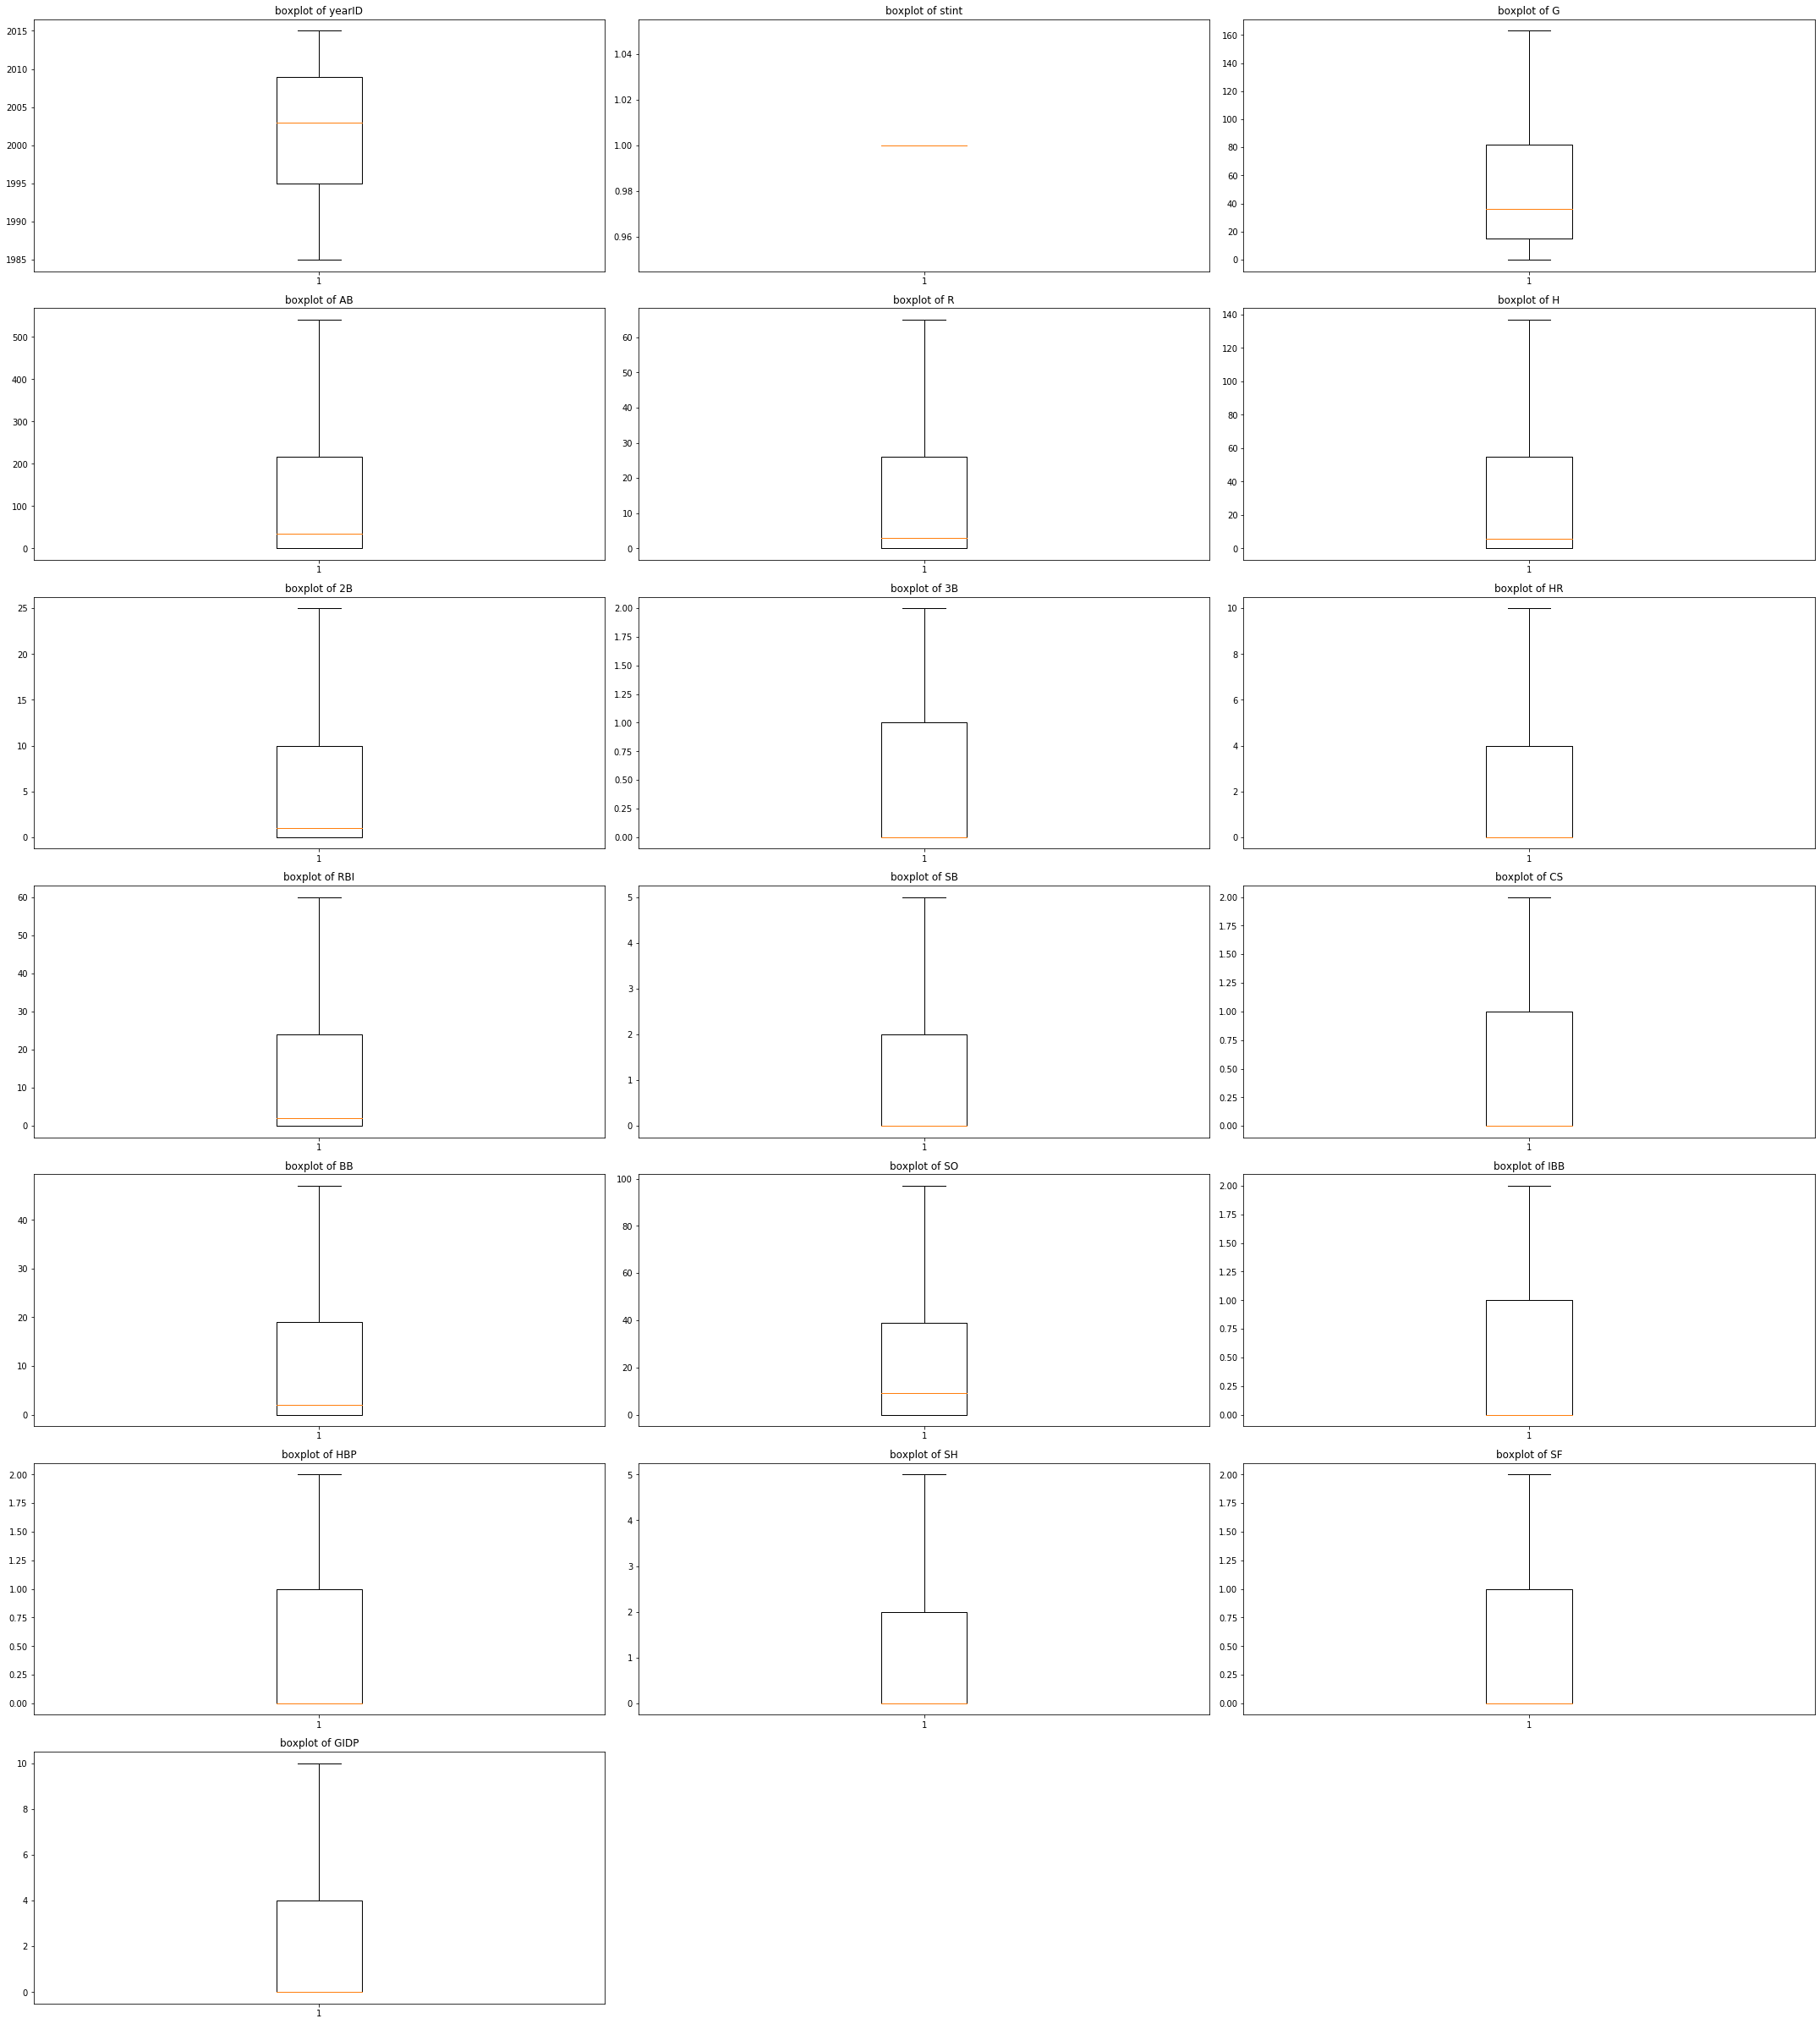

In [17]:
boxplot(batting, (30,90), 3)

In [18]:
# stint only has the one value. I'll drop it
batting.drop(['stint'], axis=1, inplace=True)

### Batting is taken care of as far as nulls and outliers go

## Nulls for pitching

In [19]:
display(nans(pitching))
pitching.isnull().sum()
## how to deal with these nulls now

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,...,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
24980,aasedo01,1985,1,BAL,AL,10,6,54,0,0,...,7.0,0.0,1.0,1,366.0,43.0,44,NaN,NaN,NaN
24981,abregjo01,1985,1,CHN,NL,1,1,6,5,0,...,1.0,0.0,0.0,0,109.0,0.0,18,NaN,NaN,NaN
24982,ackerji01,1985,1,TOR,AL,7,2,61,0,0,...,1.0,2.0,3.0,0,370.0,26.0,35,NaN,NaN,NaN
24983,agostju01,1985,1,CHA,AL,4,3,54,0,0,...,1.0,0.0,3.0,0,246.0,21.0,27,NaN,NaN,NaN
24984,aguilri01,1985,1,NYN,NL,10,7,21,19,2,...,2.0,5.0,2.0,2,507.0,1.0,49,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44134,youngch03,2015,1,KCA,AL,11,6,34,18,0,...,0.0,5.0,0.0,0,500.0,3.0,44,4.0,2.0,NaN
44135,zieglbr01,2015,1,ARI,NL,0,3,66,0,0,...,3.0,2.0,1.0,0,263.0,46.0,17,1.0,0.0,NaN
44136,zimmejo02,2015,1,WAS,NL,13,10,33,33,0,...,3.0,2.0,8.0,1,831.0,0.0,89,8.0,2.0,NaN
44137,zitoba01,2015,1,OAK,AL,0,0,3,2,0,...,0.0,0.0,0.0,0,37.0,1.0,8,0.0,0.0,NaN


playerID        0
yearID          0
stint           0
teamID          0
lgID            0
W               0
L               0
G               0
GS              0
CG              0
SHO             0
SV              0
IPouts          1
H               0
ER              0
HR              0
BB              0
SO              0
BAOpp         640
ERA            19
IBB             0
WP              0
HBP             1
BK              0
BFP             0
GF              0
R               0
SH           7920
SF           7920
GIDP        18414
dtype: int64

In [20]:
pitching.describe()

,yearID,stint,W,L,G,GS,CG,SHO,SV,IPouts,...,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
count,19159.000000,19159.000000,19159.000000,19159.000000,19159.000000,19159.000000,19159.000000,19159.000000,19159.000000,19158.000000,...,19159.000000,19159.000000,19158.000000,19159.000000,19159.000000,19159.000000,19159.000000,11239.000000,11239.000000,745.000000
mean,2001.424866,1.083929,3.703795,3.703795,26.160029,7.409677,0.450545,0.145989,1.865703,198.586961,...,2.012631,2.391826,2.247312,0.356229,284.753223,6.959131,33.840910,2.207759,1.908088,4.844295
std,8.741779,0.289085,4.452438,3.852186,20.419301,11.134290,1.419866,0.529960,6.575536,190.971385,...,2.324798,2.771923,2.703938,0.872069,267.955396,11.596099,31.342603,2.751917,2.143002,5.524863
min,1985.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1994.000000,1.000000,0.000000,1.000000,9.000000,0.000000,0.000000,0.000000,0.000000,48.000000,...,0.000000,0.000000,0.000000,0.000000,74.000000,0.000000,10.000000,0.000000,0.000000,1.000000
50%,2002.000000,1.000000,2.000000,2.000000,22.000000,0.000000,0.000000,0.000000,0.000000,140.000000,...,1.000000,2.000000,1.000000,0.000000,205.000000,2.000000,23.000000,1.000000,1.000000,3.000000
75%,2009.000000,1.000000,5.000000,6.000000,35.000000,12.000000,0.000000,0.000000,0.000000,268.000000,...,3.000000,4.000000,3.000000,0.000000,385.000000,9.000000,48.000000,3.000000,3.000000,7.000000
max,2015.000000,4.000000,27.000000,21.000000,94.000000,40.000000,20.000000,10.000000,62.000000,856.000000,...,18.000000,26.000000,21.000000,16.000000,1231.000000,79.000000,160.000000,21.000000,14.000000,36.000000


In [21]:
def get_k(df):
    k = round(np.sqrt((len(df)*0.75)))
    return k
print(get_k(pitching))
print(pitching.info())
k_pitching = get_k(pitching)

120.0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 19159 entries, 24980 to 44138
Data columns (total 30 columns):
playerID    19159 non-null object
yearID      19159 non-null int64
stint       19159 non-null int64
teamID      19159 non-null object
lgID        19159 non-null object
W           19159 non-null int64
L           19159 non-null int64
G           19159 non-null int64
GS          19159 non-null int64
CG          19159 non-null int64
SHO         19159 non-null int64
SV          19159 non-null int64
IPouts      19158 non-null float64
H           19159 non-null int64
ER          19159 non-null int64
HR          19159 non-null int64
BB          19159 non-null int64
SO          19159 non-null int64
BAOpp       18519 non-null float64
ERA         19140 non-null float64
IBB         19159 non-null float64
WP          19159 non-null float64
HBP         19158 non-null float64
BK          19159 non-null int64
BFP         19159 non-null float64
GF          19159 non-null float64
R   

In [22]:
print(pitching.GIDP.notnull().sum()/len(pitching))
print(pitching.GIDP.isnull().sum()/len(pitching))
# GIDP stands for ground into double play. Given the fact that there is less than 5% non-null values.
# I am going to drop this variable. Especially because it doesn't make sense to turn this
# into a boolean
pitching.drop(['GIDP'], axis=1, inplace=True)

0.03888511926509734
0.9611148807349027


In [23]:
# I will drop all categorical variables like teamID, playerID, and lgId.
# They have no significance

impute_list = ['BAOpp', 'IPouts', 'HBP', 'ERA', 'SH', 'SF']

for col in impute_list:
    pitching[col] = knn_impute(target=pitching[col], attributes=pitching.drop(['teamID', 'playerID', 'lgID', col], 1),
                                    aggregation_method="median", k_neighbors=120, numeric_distance='euclidean',
                                    categorical_distance='hamming', missing_neighbors_threshold=1)

In [24]:
print(pitching.isnull().sum())

playerID     0
yearID       0
stint        0
teamID       0
lgID         0
W            0
L            0
G            0
GS           0
CG           0
SHO          0
SV           0
IPouts       0
H            0
ER           0
HR           0
BB           0
SO           0
BAOpp        0
ERA          0
IBB          0
WP           0
HBP          0
BK           0
BFP          0
GF           0
R            0
SH          85
SF          85
dtype: int64


In [25]:
impute_list2 = ['SH', 'SF']

for col in impute_list2:
    pitching[col] = knn_impute(target=pitching[col], attributes=pitching.drop(['teamID', 'playerID', 'lgID', col], 1),
                                    aggregation_method="median", k_neighbors=120, numeric_distance='euclidean',
                                    categorical_distance='hamming', missing_neighbors_threshold=0.9)

In [26]:
print(pitching.isnull().sum())
print(pitching.info())

playerID    0
yearID      0
stint       0
teamID      0
lgID        0
W           0
L           0
G           0
GS          0
CG          0
SHO         0
SV          0
IPouts      0
H           0
ER          0
HR          0
BB          0
SO          0
BAOpp       0
ERA         0
IBB         0
WP          0
HBP         0
BK          0
BFP         0
GF          0
R           0
SH          0
SF          0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 19159 entries, 24980 to 44138
Data columns (total 29 columns):
playerID    19159 non-null object
yearID      19159 non-null int64
stint       19159 non-null int64
teamID      19159 non-null object
lgID        19159 non-null object
W           19159 non-null int64
L           19159 non-null int64
G           19159 non-null int64
GS          19159 non-null int64
CG          19159 non-null int64
SHO         19159 non-null int64
SV          19159 non-null int64
IPouts      19159 non-null float64
H           19159 non-null int64
E

In [27]:
display(pitching.head())

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,...,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,SF
24980,aasedo01,1985,1,BAL,AL,10,6,54,0,0,...,3.78,7.0,0.0,1.0,1,366.0,43.0,44,3.0,3.0
24981,abregjo01,1985,1,CHN,NL,1,1,6,5,0,...,6.38,1.0,0.0,0.0,0,109.0,0.0,18,1.0,0.0
24982,ackerji01,1985,1,TOR,AL,7,2,61,0,0,...,3.23,1.0,2.0,3.0,0,370.0,26.0,35,4.0,3.0
24983,agostju01,1985,1,CHA,AL,4,3,54,0,0,...,3.58,1.0,0.0,3.0,0,246.0,21.0,27,3.0,2.0
24984,aguilri01,1985,1,NYN,NL,10,7,21,19,2,...,3.24,2.0,5.0,2.0,2,507.0,1.0,49,4.5,3.0


In [28]:
def numeric_columns(df):
    lst = list(df.select_dtypes(exclude='object'))
    return lst

numeric_columns(pitching)

['yearID',
 'stint',
 'W',
 'L',
 'G',
 'GS',
 'CG',
 'SHO',
 'SV',
 'IPouts',
 'H',
 'ER',
 'HR',
 'BB',
 'SO',
 'BAOpp',
 'ERA',
 'IBB',
 'WP',
 'HBP',
 'BK',
 'BFP',
 'GF',
 'R',
 'SH',
 'SF']

In [29]:
check_outliers(pitching)

Number of outliers and percentage of it in yearID : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in stint : 1547 and %8.074534161490684
percent of outliers low
0.0
Percent of outliers high
0.08074534161490683
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in W : 1264 and %6.597421577326583
percent of outliers low
0.0
Percent of outliers high
0.06597421577326583
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in L : 429 and %2.2391565321780886
percent of outliers low
0.0
Percent of outliers high
0.022391565321780885
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in G : 324 and %1.691111227

In [30]:
winsorize_outliers(pitching)
check_outliers(pitching)

Number of outliers and percentage of it in yearID : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in stint : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in W : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in L : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in G : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
----------------------------------------------------

In [31]:
#one always seems to sneak through
pitching['SO'] = winsorize(pitching['SO'], (0, 0.0485))
check_outliers(pitching)

Number of outliers and percentage of it in yearID : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in stint : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in W : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in L : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in G : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
----------------------------------------------------

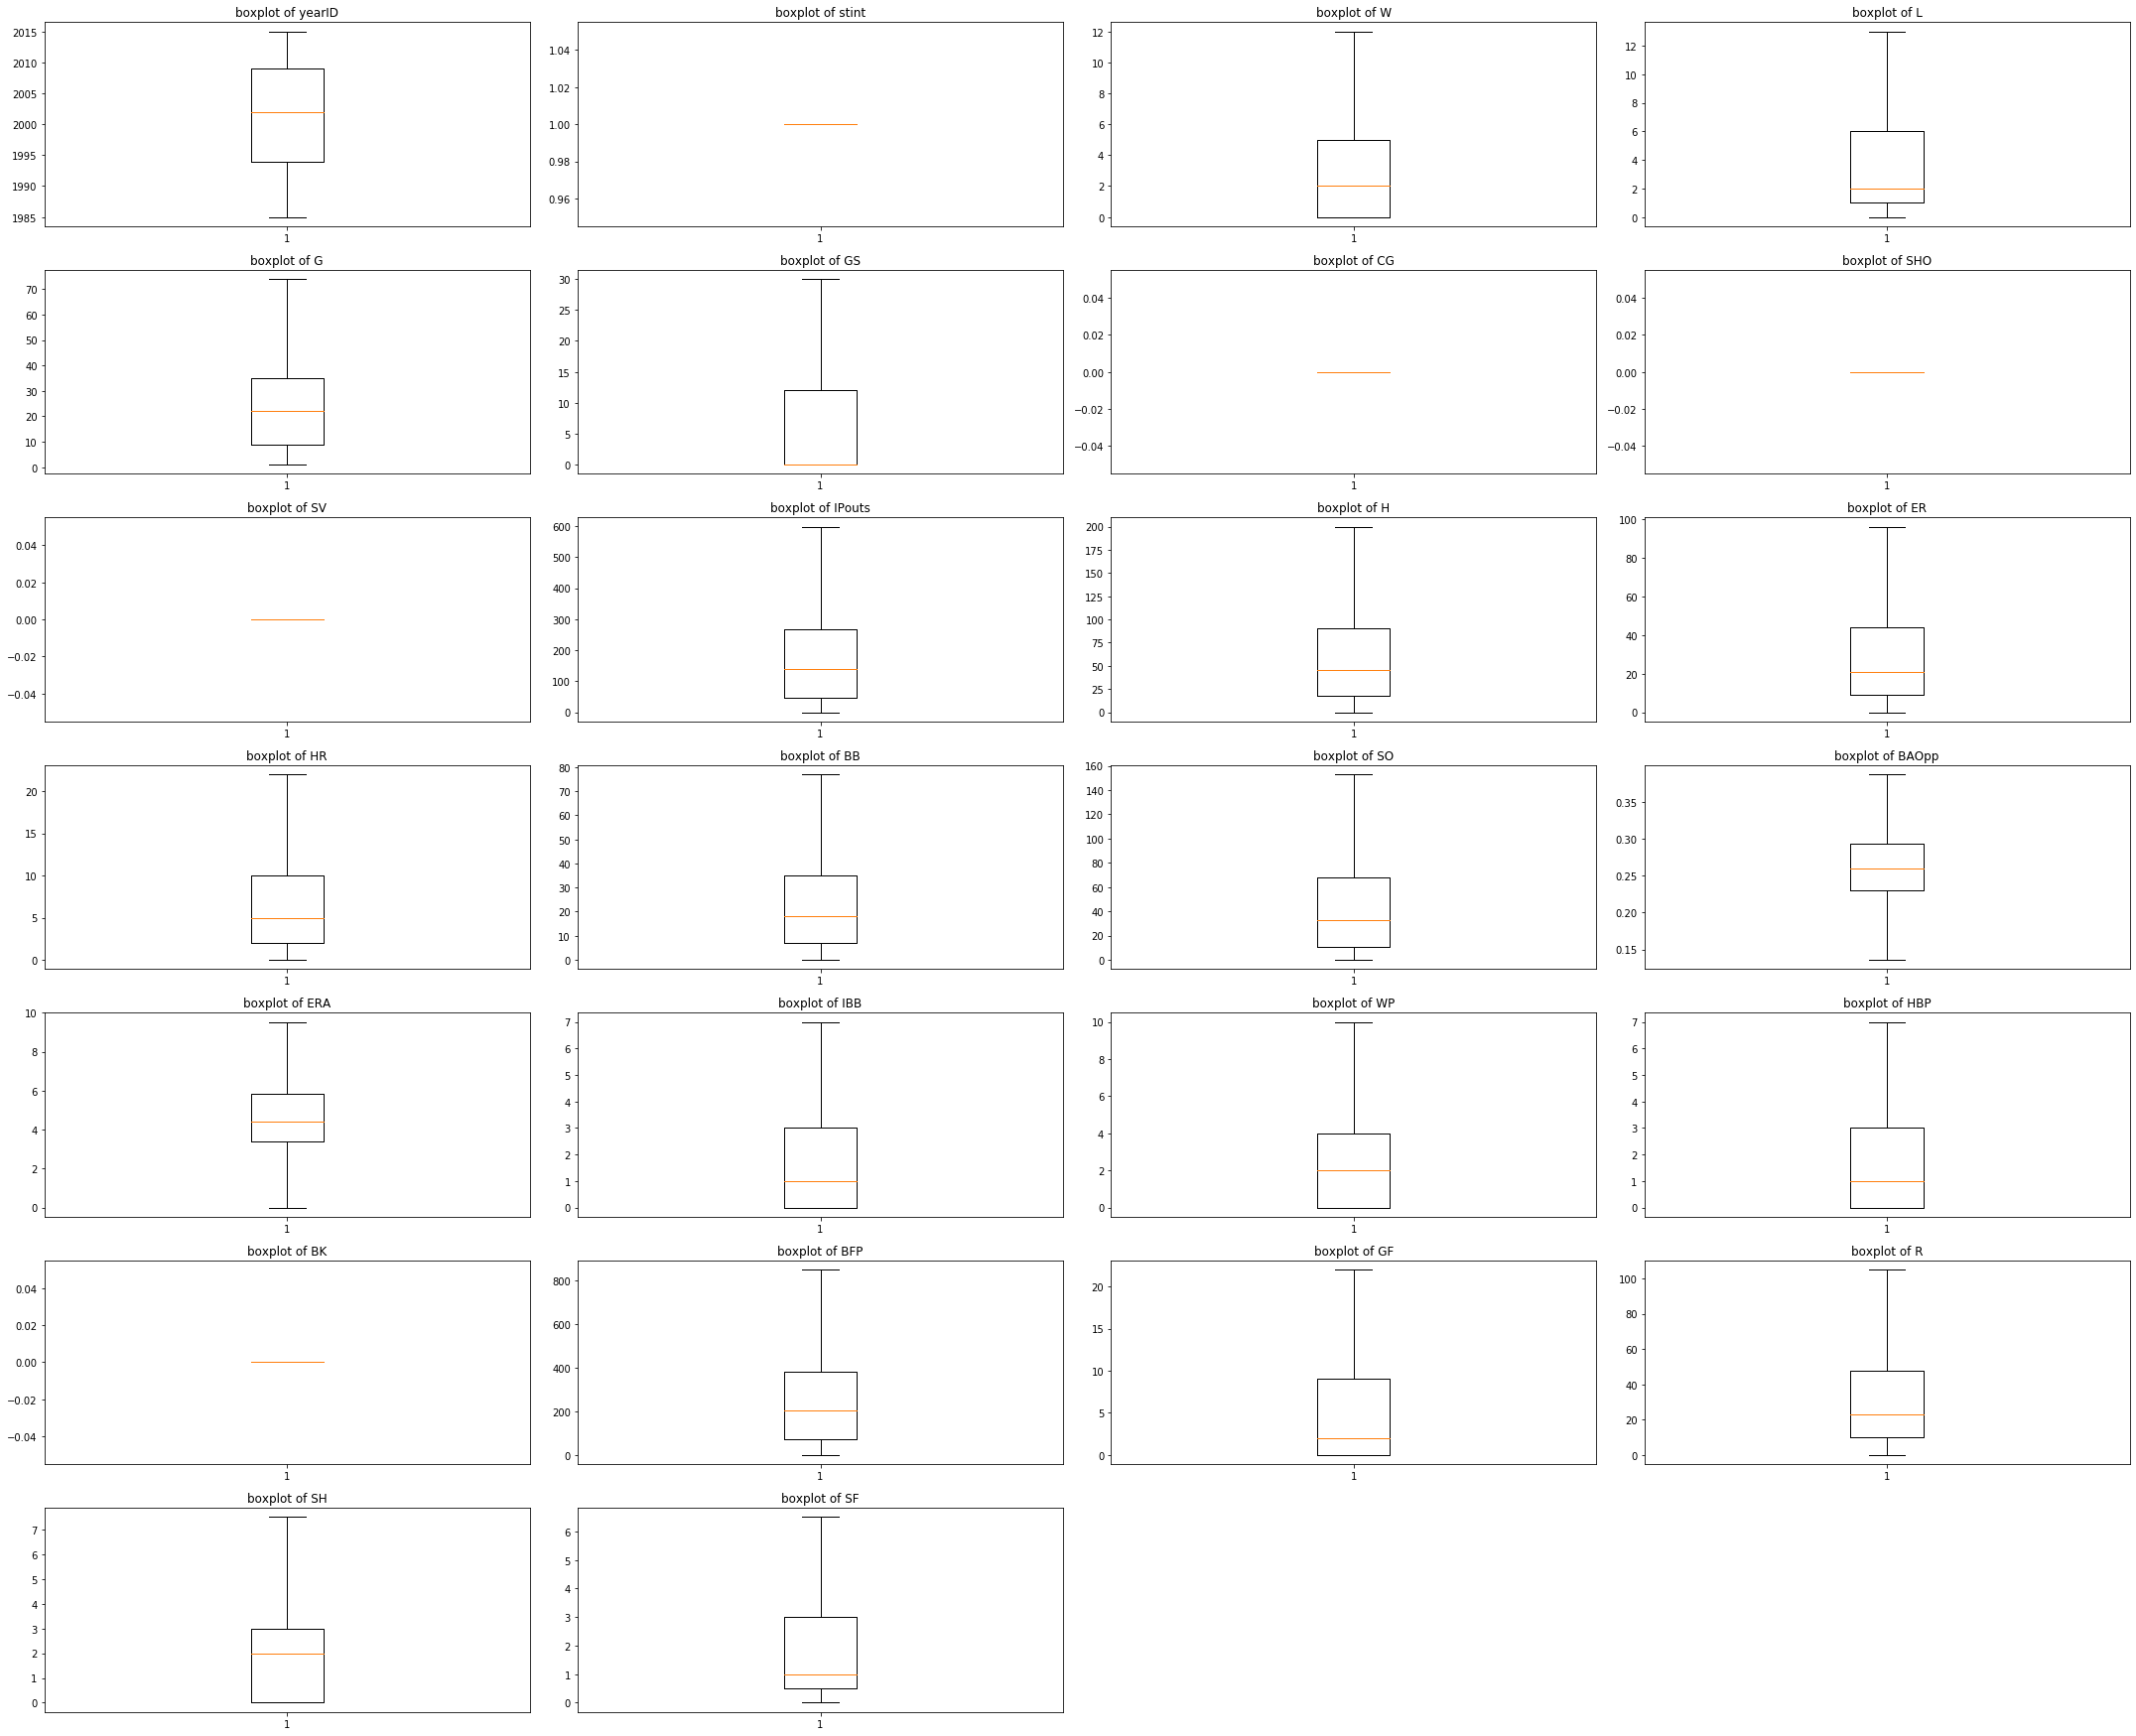

In [32]:
boxplot(pitching, (30,90), 4)

In [33]:
# looks like some of these variables 
# only have one value. Not very helpful
def unique(df, lst):
    for var in lst:
        print(var)
        print(df[var].unique())
        print('='*40)
    
lst = ['stint', 'CG', 'SHO', 'SV', 'BK']

unique(pitching, lst)

stint
[1]
CG
[0]
SHO
[0]
SV
[0]
BK
[0]


In [34]:
#Those variables are obviously not helpful. I'll drop them
pitching.drop(['stint', 'CG', 'SHO', 'SV', 'BK'], axis=1, inplace=True)
print(pitching.columns)

Index(['playerID', 'yearID', 'teamID', 'lgID', 'W', 'L', 'G', 'GS', 'IPouts',
       'H', 'ER', 'HR', 'BB', 'SO', 'BAOpp', 'ERA', 'IBB', 'WP', 'HBP', 'BFP',
       'GF', 'R', 'SH', 'SF'],
      dtype='object')


In [35]:
print(salary['playerID'].isin(pitching['playerID']).value_counts())
print(salary['playerID'].isin(batting['playerID']).value_counts())
print(salary['playerID'].isin(fielding['playerID']).value_counts())
print(fielding['playerID'].isin(batting['playerID']).value_counts())

True     13024
False    12551
Name: playerID, dtype: int64
True     25212
False      363
Name: playerID, dtype: int64
True     25554
False       21
Name: playerID, dtype: int64
True     70838
False      653
Name: playerID, dtype: int64


### Nulls and outliers are taken care of on pitching 

# Fielding

In [36]:
display(fielding.head())

,playerID,yearID,stint,teamID,lgID,POS,G,GS,InnOuts,PO,A,E,DP,PB,WP,SB,CS,ZR
99035,aasedo01,1985,1,BAL,AL,P,54,0.0,264.0,8.0,10.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
99036,abregjo01,1985,1,CHN,NL,P,6,5.0,72.0,1.0,6.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN
99037,ackerji01,1985,1,TOR,AL,P,61,0.0,259.0,10.0,16.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN
99038,adamsri02,1985,1,SFN,NL,2B,6,3.0,84.0,9.0,13.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
99039,adamsri02,1985,1,SFN,NL,3B,16,10.0,337.0,2.0,31.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN


In [37]:
display(fielding.describe())

,yearID,stint,G,GS,InnOuts,PO,A,E,DP,PB,WP,SB,CS,ZR
count,71491.000000,71491.000000,71491.000000,30337.000000,56801.000000,59376.000000,59376.000000,59376.000000,59376.000000,3418.000000,1583.000000,3418.000000,3418.000000,1583.000000
mean,2000.443650,1.080849,32.926103,25.402907,673.166511,71.836786,24.972346,1.788787,5.999596,3.063487,13.080227,27.260971,11.767993,0.471889
std,8.864888,0.286222,39.907067,39.732776,1036.392394,165.676080,67.177903,3.428706,18.285871,3.573765,13.076765,27.135464,12.550011,1.126763
min,1985.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1993.000000,1.000000,4.000000,1.000000,54.000000,2.000000,1.000000,0.000000,0.000000,0.000000,2.000000,4.000000,1.000000,0.000000
50%,2000.000000,1.000000,16.000000,6.000000,204.000000,9.000000,4.000000,0.000000,0.000000,2.000000,9.000000,19.000000,8.000000,0.000000
75%,2008.000000,1.000000,45.000000,30.000000,681.000000,56.000000,15.000000,2.000000,2.000000,5.000000,21.500000,43.000000,19.000000,1.000000
max,2015.000000,4.000000,163.000000,162.000000,4389.000000,1597.000000,570.000000,42.000000,176.000000,35.000000,69.000000,155.000000,89.000000,15.000000


In [38]:
print(len(fielding), '\n')
print(fielding.info())

71491 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71491 entries, 99035 to 170525
Data columns (total 18 columns):
playerID    71491 non-null object
yearID      71491 non-null int64
stint       71491 non-null int64
teamID      71491 non-null object
lgID        71491 non-null object
POS         71491 non-null object
G           71491 non-null int64
GS          30337 non-null float64
InnOuts     56801 non-null float64
PO          59376 non-null float64
A           59376 non-null float64
E           59376 non-null float64
DP          59376 non-null float64
PB          3418 non-null float64
WP          1583 non-null float64
SB          3418 non-null float64
CS          3418 non-null float64
ZR          1583 non-null float64
dtypes: float64(11), int64(3), object(4)
memory usage: 10.4+ MB
None


In [39]:
print(fielding.isnull().sum())
print(fielding.isnull().sum()/len(fielding)*100)

playerID        0
yearID          0
stint           0
teamID          0
lgID            0
POS             0
G               0
GS          41154
InnOuts     14690
PO          12115
A           12115
E           12115
DP          12115
PB          68073
WP          69908
SB          68073
CS          68073
ZR          69908
dtype: int64
playerID     0.000000
yearID       0.000000
stint        0.000000
teamID       0.000000
lgID         0.000000
POS          0.000000
G            0.000000
GS          57.565288
InnOuts     20.548041
PO          16.946189
A           16.946189
E           16.946189
DP          16.946189
PB          95.218979
WP          97.785735
SB          95.218979
CS          95.218979
ZR          97.785735
dtype: float64


In [40]:
display(fielding[['ZR', 'CS', 'SB', 'WP', 'PB']].dropna())
display(fielding[['PB', 'SB', 'CS']].dropna())

,ZR,CS,SB,WP,PB
99048,0.0,2.0,3.0,1.0,0.0
99068,0.0,21.0,58.0,19.0,14.0
99076,0.0,33.0,73.0,43.0,19.0
99096,1.0,19.0,53.0,21.0,3.0
99137,1.0,24.0,65.0,9.0,1.0
...,...,...,...,...,...
132354,1.0,29.0,101.0,26.0,8.0
132356,0.0,0.0,0.0,0.0,0.0
132381,2.0,25.0,78.0,45.0,3.0
132390,0.0,0.0,0.0,0.0,0.0


,PB,SB,CS
99048,0.0,3.0,2.0
99068,14.0,58.0,21.0
99076,19.0,73.0,33.0
99096,3.0,53.0,19.0
99137,1.0,65.0,24.0
...,...,...,...
168859,2.0,18.0,8.0
168860,1.0,1.0,1.0
168861,0.0,15.0,6.0
168862,2.0,13.0,4.0


When looking at these variables, it seems hard to leave them in as a feature. From what it looks like, these observations all share the same indexes and are continuous in nature. There isn't enough information to reasonably impute the missing data or to treat them as dummy columns or label encoded. I will drop those variables outright.

In [41]:
fielding = fielding.drop(['ZR', 'CS', 'SB', 'WP', 'PB'], axis=1)


In [42]:
display(fielding.head())
fielding.info()

,playerID,yearID,stint,teamID,lgID,POS,G,GS,InnOuts,PO,A,E,DP
99035,aasedo01,1985,1,BAL,AL,P,54,0.0,264.0,8.0,10.0,0.0,0.0
99036,abregjo01,1985,1,CHN,NL,P,6,5.0,72.0,1.0,6.0,1.0,0.0
99037,ackerji01,1985,1,TOR,AL,P,61,0.0,259.0,10.0,16.0,0.0,1.0
99038,adamsri02,1985,1,SFN,NL,2B,6,3.0,84.0,9.0,13.0,1.0,1.0
99039,adamsri02,1985,1,SFN,NL,3B,16,10.0,337.0,2.0,31.0,1.0,3.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 71491 entries, 99035 to 170525
Data columns (total 13 columns):
playerID    71491 non-null object
yearID      71491 non-null int64
stint       71491 non-null int64
teamID      71491 non-null object
lgID        71491 non-null object
POS         71491 non-null object
G           71491 non-null int64
GS          30337 non-null float64
InnOuts     56801 non-null float64
PO          59376 non-null float64
A           59376 non-null float64
E           59376 non-null float64
DP          59376 non-null float64
dtypes: float64(6), int64(3), object(4)
memory usage: 7.6+ MB


In [43]:
print(fielding.isnull().sum())

playerID        0
yearID          0
stint           0
teamID          0
lgID            0
POS             0
G               0
GS          41154
InnOuts     14690
PO          12115
A           12115
E           12115
DP          12115
dtype: int64


In [44]:
get_k(fielding)

232.0

In [ ]:
impute_list = ['GS', 'InnOuts', 'PO', 'A', 'E', 'DP']

for col in impute_list:
    fielding[col] = knn_impute(target=fielding[col], attributes=fielding.drop(['teamID', 'playerID', 'lgID', col], 1),
                                    aggregation_method="median", k_neighbors=232, numeric_distance='euclidean',
                                    categorical_distance='hamming', missing_neighbors_threshold=1)

In [ ]:
'''fielding['PO'] = knn_impute(target=fielding['PO'], attributes=fielding.drop(['teamID', 'playerID', 'lgID', 'GS', 'InnOuts'], 1),
                                    aggregation_method="median", k_neighbors=k, numeric_distance='euclidean',
                                    categorical_distance='hamming', missing_neighbors_threshold=0.5)'''

# ^^^^^^^^^^
## Return here

In [ ]:
salary.isnull().sum()

In [ ]:
check_outliers(salary)

In [ ]:
salary['salary'] = winsorize(salary['salary'], (0,0.1114))

In [ ]:
check_outliers(salary)

In [ ]:
'''fielding_batting = pd.merge(fielding, batting, 
                            on=['playerID', 'yearID', 'teamID', 'lgID', 'stint'],
                            how='inner')'''

In [ ]:
'''print(fielding_batting.shape)
print(fielding.shape)
print(batting.shape)
print(salary.shape)
display(fielding_batting.head())'''

In [ ]:
'''print(fielding.columns)
print(batting.columns)
print(fielding_batting.columns)
print(fielding_batting.isnull().sum())
print(salary.columns)'''

In [ ]:
'''impute_list = ['PO', 'A', 'E', 'DP', 'GS']

for col in impute_list:
    fielding[col] = knn_impute(target=fielding[col], attributes=fielding.drop(['teamID', 'playerID', 'lgID', col], 1),
                                    aggregation_method="median", k_neighbors=k, numeric_distance='euclidean',
                                    categorical_distance='hamming', missing_neighbors_threshold=0.75)'''

In [ ]:
'''full_df = pd.merge(fielding_batting, 
                   salary, 
                   on=['yearID', 'teamID', 'lgID', 'playerID'])'''

In [ ]:
'''print(batting.columns)
print(full_df.shape)
print(full_df.isnull().sum())
print(full_df['POS'].unique())
print(full_df.loc[full_df.POS == 'P'])'''

In [ ]:
display(full_df.head())

In [ ]:
nans(full_df)

In [ ]:
print(full_df.isnull().sum())

In [ ]:
## Merge pitching with salary to get my target variable

In [ ]:
pitching_full = pd.merge(pitching, salary, on=['yearID', 'playerID', 'teamID', 'lgID'])

In [ ]:
print(pitching_full.isnull().sum())
check_outliers(pitching_full)
winsorize_outliers(pitching_full)
check_outliers(pitching_full)


In [ ]:
pitching_full = pitching_full.interpolate()
print(len(pitching_full))
print(len(pitching))

In [ ]:
boxplot(pitching_full,(30,90), 3)

In [ ]:
boxplot(pitching_full, (30,90), 3)

In [ ]:
y = pitching_full.salary
X = pitching_full.drop(['salary', 'teamID', 'playerID', 'lgID'], axis=1)

# Standarizing the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Computing the first principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_std,
    X_pca,
    test_size=0.5,
    )
print(X.shape, y.shape, X_half1.shape, X_half2.shape, X_pcahalf1.shape, X_pcahalf2.shape)

## K-Means

In [ ]:
# Get predicted clusters.
full_pred = KMeans(n_clusters=2).fit_predict(X_std)

pd.crosstab(y, full_pred) 

In [ ]:

def kmeans_silhouette(range_num, x):
    from sklearn.cluster import KMeans
    for num in range(1, range_num, 1):
        pred = KMeans(n_clusters=num).fit_predict(x)
        labels = KMeans(n_clusters=num).fit_predict(x)
        print("ARI for {} cluster k-means: {}".format(num,
                                                      metrics.adjusted_rand_score(y, pred)))
        print('Silhouette score {} cluster k-means: {}'.format(num,
                                                               metrics.silhouette_score, labels, metric='euclidian'))
        print('='*40)

In [ ]:
kmeans_silhouette(6, X_std)

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
min_samples_list = range(2,51)

for i in range(2,51):
    dbscan_cluster = DBSCAN(eps=1, min_samples=i, metric="euclidean")
    # Fit model
    clusters = dbscan_cluster.fit_predict(X_std)
    print("Number of clusters when min_samples={} is: {}".format(i, len(np.unique(clusters))))

In [ ]:
for i in [0.01,0.1,1,2,3,4,5,6,7,8,9,10]:
    dbscan_cluster = DBSCAN(eps=i, min_samples=1, metric="euclidean")
    # Fit model
    clusters = dbscan_cluster.fit_predict(X_std)
    print("Number of clusters when eps={} is: {}".format(i, len(np.unique(clusters))))